In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import tensorflow as tf

## Label enconding and decoding

In [2]:
label_code = {'Eight':0,'Half':1,'Quarter':2,'Sixteenth':3,'Whole':4}
label_decode = ['Eight','Half','Quarter','Sixteenth','Whole']

## Dataframe for datasets

In [3]:
df = pd.DataFrame(columns = ['path', 'label'])

In [4]:
for dirname, _, filenames in os.walk('../input/music-notes-datasets/datasets/datasets/Notes'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        name = dirname.split('/')[-1]
        label = label_code[name]
        df = df.append({'path' : path, 'label' : label}, ignore_index = True)

In [5]:
df.head()

,path,label
0,../input/music-notes-datasets/datasets/dataset...,3
1,../input/music-notes-datasets/datasets/dataset...,3
2,../input/music-notes-datasets/datasets/dataset...,3
3,../input/music-notes-datasets/datasets/dataset...,3
4,../input/music-notes-datasets/datasets/dataset...,3


## Trainning testing split

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state = 77)

In [7]:
train.head()

,path,label
336,../input/music-notes-datasets/datasets/dataset...,3
3473,../input/music-notes-datasets/datasets/dataset...,4
2900,../input/music-notes-datasets/datasets/dataset...,2
66,../input/music-notes-datasets/datasets/dataset...,3
1737,../input/music-notes-datasets/datasets/dataset...,0


In [8]:
test.head()

,path,label
4003,../input/music-notes-datasets/datasets/dataset...,1
2314,../input/music-notes-datasets/datasets/dataset...,2
3778,../input/music-notes-datasets/datasets/dataset...,4
100,../input/music-notes-datasets/datasets/dataset...,3
2968,../input/music-notes-datasets/datasets/dataset...,2


# DATA LOADER

In [9]:
from tensorflow.keras.preprocessing.image import load_img

class dataloader(tf.keras.utils.Sequence):
       
    def __init__(self, batch_size, img_width, img_height, data):
        self.bs = batch_size
        self.h = img_height
        self.w = img_width
        self.path = data['path'].values
        self.label = data['label'].values
        
    def __len__(self):
        return len(self.path) // self.bs
    
    def __getitem__(self, idx):
        
        i = idx * self.bs
        batch_paths = self.path[i : i + self.bs]
        batch_labels = self.label[i : i + self.bs]
        
        X = np.zeros((self.bs, self.h, self.w, 3), dtype="float32")
        y = np.zeros((self.bs, 5), dtype="int32")
        
        for j in range(self.bs): 
            img = load_img(batch_paths[j], color_mode = "rgb", target_size=(self.h, self.w)) # color_mode = "grayscale" 
            img = np.array(img, dtype = 'float32') 
            img = 1-img/127.5
            X[j] = img     
            y[j,batch_labels[j]] = 1  
        return X, y

In [10]:
train_gen = dataloader(5, 224, 224, train)

test_gen = dataloader(5, 224, 224, test)

## Testing samples

In [11]:
batch1 = test_gen[3]

images = batch1[0]

labels = batch1[1]

print("images in batch = ", images.shape)
print("labels in batch = ", labels.shape)

images in batch =  (5, 224, 224, 3)
labels in batch =  (5, 5)


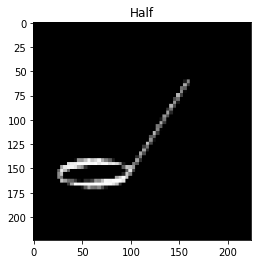

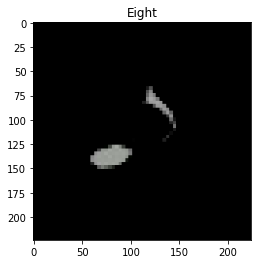

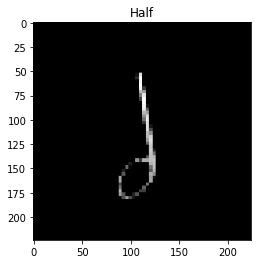

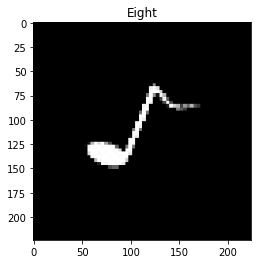

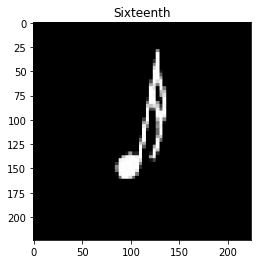

In [12]:
for i, j in zip(images, labels):
    plt.subplots()
    plt.imshow(i)
    plt.title(label_decode[np.argmax(j)])

## MODEL SETUP

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(4, (4, 4), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(Conv2D(3, (3, 3), activation='relu'))
model.add(Conv2D(3, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(5,activation='softmax'))    #output_channel = 5

2022-02-01 06:08:47.153146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 06:08:47.259243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 06:08:47.259994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 06:08:47.261128: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 219, 219, 4)       516       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 4)       148       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 105, 3)       111       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 103, 103, 3)       84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 51, 3)         0

## TRAINNING

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [16]:
model.fit(train_gen, epochs=20, validation_data=test_gen, verbose=1)

2022-02-01 06:08:49.847741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-01 06:08:51.083150: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


800/800 [==============================] - 24s 22ms/step - loss: 0.6518 - accuracy: 0.7430 - val_loss: 0.2600 - val_accuracy: 0.9060
Epoch 2/20
800/800 [==============================] - 9s 11ms/step - loss: 0.2048 - accuracy: 0.9260 - val_loss: 0.1425 - val_accuracy: 0.9560
Epoch 3/20
800/800 [==============================] - 9s 11ms/step - loss: 0.0922 - accuracy: 0.9695 - val_loss: 0.1092 - val_accuracy: 0.9530
Epoch 4/20
800/800 [==============================] - 9s 11ms/step - loss: 0.0740 - accuracy: 0.9758 - val_loss: 0.1018 - val_accuracy: 0.9630
Epoch 5/20
800/800 [==============================] - 9s 11ms/step - loss: 0.0622 - accuracy: 0.9827 - val_loss: 0.1169 - val_accuracy: 0.9600
Epoch 6/20
800/800 [==============================] - 8s 11ms/step - loss: 0.0399 - accuracy: 0.9885 - val_loss: 0.0786 - val_accuracy: 0.9760
Epoch 7/20
800/800 [==============================] - 9s 11ms/step - loss: 0.0234 - accuracy: 0.9925 - val_loss: 0.0974 - val_accuracy: 0.9710
Epoch 8/2

## TESTING ON SINGLE IMAGE

In [17]:
path = '../input/music-notes-datasets/datasets/datasets/Notes/Sixteenth/s1.jpg'

img = load_img(path , color_mode = "rgb", target_size=(224, 224)) # (h ,w) color_mode = "grayscale" 
img = np.array(img, dtype = 'float32') 
img = 1-img/127.5

img = img.reshape(1,224,224,3)

y1 = model.predict(img)

In [18]:
s = np.argmax(y1)

print(label_decode[s])

Sixteenth
